In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set text cutoff fo
pd.set_option('display.max_colwidth', 1000)

In [2]:
mistral_frame = pd.read_csv("../processed_data/cc_mistral_ratings.csv")
chatgpt_frame = pd.read_csv("../processed_data/gptrated_frame.csv")

edstays = pd.read_csv("../raw_data/edstay_encounters.csv")

In [26]:
edstays.dbp.describe()

count    405996.000000
mean         81.262126
std        1057.220031
min           0.000000
25%          68.000000
50%          77.000000
75%          87.000000
max      661672.000000
Name: dbp, dtype: float64

In [4]:
# cast all chiefcomplaints to string
edstays["chiefcomplaint"] = edstays["chiefcomplaint"].astype(str)

# get min, max and mean word count for each chief complaint
edstays["word_count"] = edstays["chiefcomplaint"].apply(lambda x: len(x.split()))
edstays["word_count"].describe()

count    425087.000000
mean          2.430143
std           1.237065
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          16.000000
Name: word_count, dtype: float64

In [5]:
# get min, max and mean character count for each chief complaint
edstays["char_count"] = edstays["chiefcomplaint"].apply(lambda x: len(x))
edstays["char_count"].describe()

count    425087.000000
mean         14.555416
std           8.051033
min           1.000000
25%           8.000000
50%          13.000000
75%          19.000000
max         136.000000
Name: char_count, dtype: float64

In [8]:
cat_features = ["pain", "acuity", "gender", "arrival_transport"]

In [22]:
edstays.los.describe()

count    425087.000000
mean        429.499604
std         397.679997
min       -1364.000000
25%         212.000000
50%         328.000000
75%         499.000000
max       29584.166667
Name: los, dtype: float64

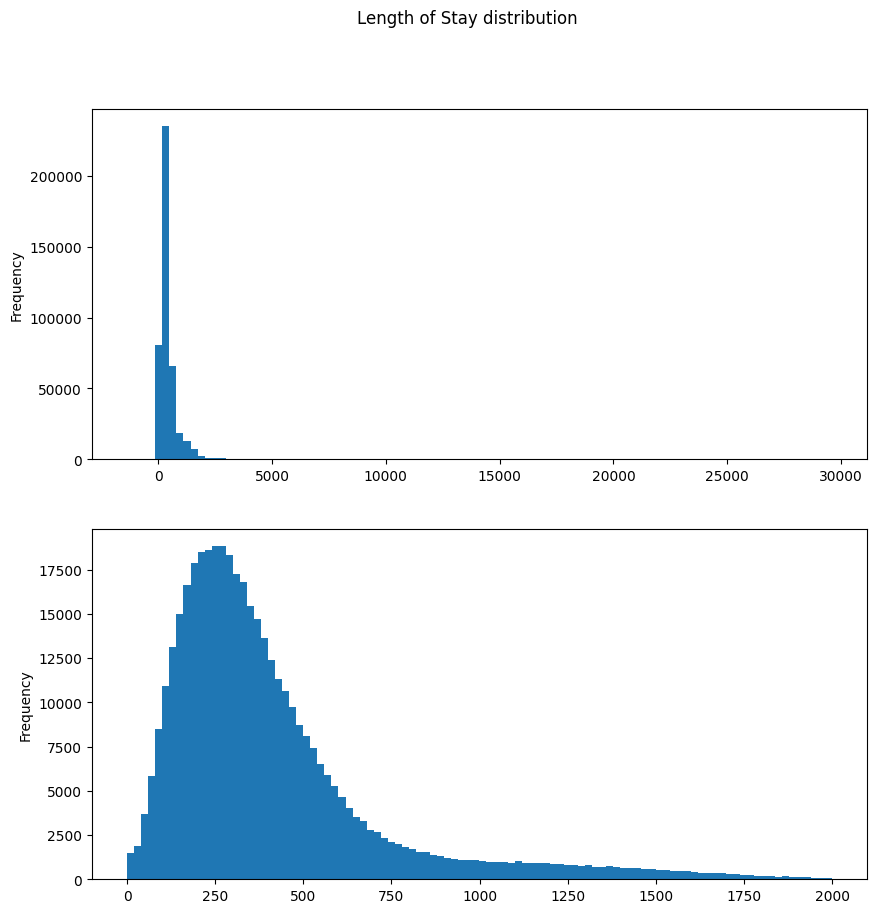

In [24]:
# histplot of los with all values and second plot with values under 1000 on two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
edstays["los"].plot.hist(ax=ax[0], bins=100)
edstays["los"][edstays["los"] >= 0][edstays["los"] < 2000].plot.hist(ax=ax[1], bins=100)
plt.suptitle("Length of Stay distribution")
plt.show()

In [9]:
# describe categorical features
for feature in cat_features:
    print(edstays[feature].value_counts())

pain
0                       140719
8                        41730
10                       40914
7                        31423
5                        29210
                         ...  
ASLEEP                       1
pre-hospital                 1
declined                     1
crti                         1
Screaming in triage          1
Name: count, Length: 847, dtype: int64
acuity
3.0    225066
2.0    139411
4.0     28504
1.0     24019
5.0      1100
Name: count, dtype: int64
gender
F    229912
M    195175
Name: count, dtype: int64
arrival_transport
WALK IN       251849
AMBULANCE     155752
UNKNOWN        15352
OTHER           1266
HELICOPTER       868
Name: count, dtype: int64


In [68]:
# remove unrated from mistral -1
mistral_frame = mistral_frame[mistral_frame["rating"] != -1]

In [69]:
mistral_ed = edstays.copy()
chatgpt_ed = edstays.copy()

In [70]:
# Create a dictionary from mistral_frame
rating_dict = mistral_frame.set_index("chiefcomplaint")["rating"].to_dict()

# Map the dictionary to the 'chiefcomplaint' column in mistral_ed
mistral_ed["rating"] = mistral_ed["chiefcomplaint"].map(rating_dict)

# Replace NaN values with -9999
mistral_ed["rating"].fillna(-9999, inplace=True)

# Repeat the process for chatgpt_ed and chatgpt_frame
rating_dict = chatgpt_frame.set_index("chiefcomplaint")["rating"].to_dict()
chatgpt_ed["rating"] = chatgpt_ed["chiefcomplaint"].map(rating_dict)
chatgpt_ed["rating"].fillna(-9999, inplace=True)

/tmp/ipykernel_97375/1805082442.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mistral_ed['rating'].fillna(-9999, inplace=True)
/tmp/ipykernel_97375/1805082442.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [71]:
train_columns = [
    "temperature",
    "heartrate",
    "o2sat",
    "sbp",
    "dbp",
    "resprate",
    "pain",
    "acuity",
    "age_on_adm",
    "gender",
    "arrival_transport",
    "rating",
    "chiefcomplaint",
]
feature_column = "los"

In [72]:
mistral_train = mistral_ed[train_columns + [feature_column]]
chatgpt_train = chatgpt_ed[train_columns + [feature_column]]

In [73]:
category_cols = ["pain", "acuity", "gender", "arrival_transport"]

# cast category columns to string
mistral_train[category_cols] = mistral_train[category_cols].apply(
    lambda col: col.astype(str)
)

# replace nan in category columns with 'missing'
mistral_train[category_cols] = mistral_train[category_cols].fillna("missing")

chatgpt_train[category_cols] = chatgpt_train[category_cols].apply(
    lambda col: col.astype(str)
)

chatgpt_train[category_cols] = chatgpt_train[category_cols].fillna("missing")

/tmp/ipykernel_97375/1987198976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mistral_train[category_cols] = mistral_train[category_cols].apply(lambda col: col.astype(str))
/tmp/ipykernel_97375/1987198976.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mistral_train[category_cols] = mistral_train[category_cols].fillna('missing')
/tmp/ipykernel_97375/1987198976.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [74]:
X_mistral = mistral_train.drop(columns=[feature_column])
y_mistral = mistral_train[feature_column]

X_chatgpt = chatgpt_train.drop(columns=[feature_column])
y_chatgpt = chatgpt_train[feature_column]

In [75]:
X_mistral_train, X_mistral_test, y_mistral_train, y_mistral_test = train_test_split(
    X_mistral, y_mistral, test_size=0.2, random_state=42
)
X_chatgpt_train, X_chatgpt_test, y_chatgpt_train, y_chatgpt_test = train_test_split(
    X_chatgpt, y_chatgpt, test_size=0.2, random_state=42
)

X_mistral_test, X_mistral_val, y_mistral_test, y_mistral_val = train_test_split(
    X_mistral_test, y_mistral_test, test_size=0.5, random_state=42
)
X_chatgpt_test, X_chatgpt_val, y_chatgpt_test, y_chatgpt_val = train_test_split(
    X_chatgpt_test, y_chatgpt_test, test_size=0.5, random_state=42
)

In [76]:
chatgptpreds = pd.read_csv("../predicted_data/chatgpt35.csv")
mistralpreds = pd.read_csv("../predicted_data/mistralpreds.csv")

In [77]:
chatgptpreds["chiefcomplaint"] = X_chatgpt_test["chiefcomplaint"]
mistralpreds["chiefcomplaint"] = X_mistral_test["chiefcomplaint"]

In [78]:
chatgptpreds_with_cc = chatgptpreds.copy()
mistralpreds_with_cc = mistralpreds.copy()

# chatgptpreds_with_cc.to_csv('../predicted_data/chatgpt35_with_cc.csv', index=False)
# mistralpreds_with_cc.to_csv('../predicted_data/mistralpreds_with_cc.csv', index=False)

In [79]:
# get error from los and pred as new column
chatgptpreds["error"] = abs(chatgptpreds["los"] - chatgptpreds["pred"])
mistralpreds["error"] = abs(mistralpreds["los"] - mistralpreds["pred"])

In [80]:
# show top 10 errors
top100_chatgpt = chatgptpreds.sort_values(by="error", ascending=False).head(100)
top100_mistral = mistralpreds.sort_values(by="error", ascending=False).head(100)

In [81]:
top100_chatgpt

,temperature,heartrate,o2sat,sbp,dbp,resprate,pain,acuity,age_on_adm,gender,arrival_transport,rating,los,pred,chiefcomplaint,error
26744,NaN,92.0,100.0,142.0,75.0,16.0,0,3.0,30,M,AMBULANCE,8,8434.0,433.297322,NaN,8000.702678
19369,99.6,90.0,99.0,138.0,76.0,18.0,9,3.0,20,F,AMBULANCE,7,7064.0,405.916177,NaN,6658.083823
18343,99.2,105.0,100.0,167.0,93.0,16.0,4,3.0,37,M,WALK IN,7,6663.0,372.105296,NaN,6290.894704
4133,98.0,82.0,98.0,123.0,78.0,18.0,0,2.0,73,M,AMBULANCE,8,6023.0,526.417544,NaN,5496.582456
18965,97.7,72.0,98.0,133.0,89.0,15.0,unable,1.0,25,M,AMBULANCE,7,5892.0,462.462137,NaN,5429.537863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25204,NaN,NaN,NaN,NaN,NaN,NaN,10,3.0,51,F,WALK IN,9,2971.0,404.516634,NaN,2566.483366
28953,97.8,130.0,99.0,87.0,67.0,20.0,0,1.0,68,F,WALK IN,7,2949.0,384.434598,NaN,2564.565402
3373,99.3,104.0,98.0,122.0,80.0,18.0,0,2.0,25,F,AMBULANCE,7,3227.0,664.575732,NaN,2562.424268
37326,96.8,103.0,99.0,105.0,54.0,18.0,0,3.0,29,M,WALK IN,7,2949.0,389.749828,NaN,2559.250172


In [82]:
top100_mistral

,temperature,heartrate,o2sat,sbp,dbp,resprate,pain,acuity,age_on_adm,gender,arrival_transport,rating,los,pred,chiefcomplaint,error
26744,NaN,92.0,100.0,142.0,75.0,16.0,0,3.0,30,M,AMBULANCE,9.0,8434.0,407.285170,NaN,8026.714830
19369,99.6,90.0,99.0,138.0,76.0,18.0,9,3.0,20,F,AMBULANCE,-9999.0,7064.0,412.258895,NaN,6651.741105
18343,99.2,105.0,100.0,167.0,93.0,16.0,4,3.0,37,M,WALK IN,5.0,6663.0,374.126846,NaN,6288.873154
4133,98.0,82.0,98.0,123.0,78.0,18.0,0,2.0,73,M,AMBULANCE,-9999.0,6023.0,509.262089,NaN,5513.737911
18965,97.7,72.0,98.0,133.0,89.0,15.0,unable,1.0,25,M,AMBULANCE,7.0,5892.0,474.666008,NaN,5417.333992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15094,98.2,87.0,98.0,141.0,83.0,18.0,0,2.0,49,F,AMBULANCE,5.0,3147.0,574.027551,NaN,2572.972449
25204,NaN,NaN,NaN,NaN,NaN,NaN,10,3.0,51,F,WALK IN,5.0,2971.0,401.036789,NaN,2569.963211
18529,99.2,70.0,100.0,137.0,82.0,18.0,7,3.0,45,M,AMBULANCE,6.0,3000.0,436.090543,NaN,2563.909457
37326,96.8,103.0,99.0,105.0,54.0,18.0,0,3.0,29,M,WALK IN,5.0,2949.0,385.443307,NaN,2563.556693


In [83]:
print("Best 30 predictions for Mistral:")
mistralpreds.sort_values("error", ascending=True).head(30)

Best 30 predictions for Mistral:


,temperature,heartrate,o2sat,sbp,dbp,resprate,pain,acuity,age_on_adm,gender,arrival_transport,rating,los,pred,chiefcomplaint,error
18285,96.2,103.0,98.0,146.0,57.0,16.0,NaN,3.0,70,F,WALK IN,5.0,426.000000,426.005119,NaN,0.005119
16100,99.0,124.0,98.0,125.0,77.0,18.0,0,2.0,66,M,WALK IN,9.0,472.000000,472.005174,NaN,0.005174
16818,98.2,80.0,100.0,137.0,77.0,18.0,7.5,4.0,27,M,WALK IN,5.0,183.000000,183.010342,NaN,0.010342
34546,99.0,84.0,99.0,117.0,81.0,16.0,0,1.0,53,M,AMBULANCE,4.0,421.000000,420.987149,NaN,0.012851
28503,97.8,75.0,100.0,122.0,76.0,20.0,10,3.0,49,F,AMBULANCE,5.0,490.000000,490.013431,Chest pain,0.013431
41864,98.0,100.0,100.0,159.0,86.0,16.0,10,4.0,30,M,WALK IN,5.0,203.000000,203.038328,NaN,0.038328
20081,97.6,99.0,100.0,135.0,87.0,18.0,13,3.0,52,M,WALK IN,5.0,416.000000,416.038419,NaN,0.038419
40038,97.8,87.0,98.0,127.0,94.0,18.0,6,4.0,47,F,UNKNOWN,5.0,139.000000,138.958966,NaN,0.041034
14375,98.5,65.0,96.0,128.0,50.0,18.0,0,3.0,91,F,WALK IN,4.0,472.000000,471.952430,NaN,0.047570
618,98.6,76.0,99.0,216.0,92.0,16.0,6,2.0,55,M,WALK IN,5.0,526.483333,526.534000,NaN,0.050667


In [10]:
text_frame_mistral = pd.read_csv("../processed_data/mistral_full_data.csv")

/tmp/ipykernel_687869/842925818.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  text_frame_mistral = pd.read_csv("../processed_data/mistral_full_data.csv")


In [12]:
# drop all where llm_info is nan
text_frame_mistral = text_frame_mistral.dropna(subset=["llm_info"])
text_frame_mistral = text_frame_mistral[:50000]
text_frame_mistral.shape

(50000, 13)

In [13]:
# get average word count, average char count and std for word count and char count
text_frame_mistral["word_count"] = text_frame_mistral["llm_info"].apply(
    lambda x: len(x.split())
)
text_frame_mistral["char_count"] = text_frame_mistral["llm_info"].apply(
    lambda x: len(x)
)

text_frame_mistral["word_count"].describe()

count    50000.000000
mean       176.516600
std         55.212144
min         56.000000
25%        138.000000
50%        166.000000
75%        203.000000
max        586.000000
Name: word_count, dtype: float64

In [14]:
text_frame_mistral["char_count"].describe()

count    50000.000000
mean      1148.131960
std        354.027504
min        353.000000
25%        903.000000
50%       1078.000000
75%       1313.000000
max       3847.000000
Name: char_count, dtype: float64

In [15]:
# order by occurence of first six words
text_frame_mistral["first_four"] = text_frame_mistral["llm_info"].apply(
    lambda x: " ".join(x.split()[:4])
)

text_frame_mistral["first_four"].value_counts()

first_four
The patient is a                     33505
Summary of irregularities in          9502
The patient is an                     2485
Summary of Irregularities: -          1085
Based on the provided                  777
The patient data presented             549
The patient data presents              527
The patient data provided              387
Summary of Irregularities: 1.          370
The patient data is                    250
Summary of Irregularities in           237
The patient data lacks                  96
This patient is a                       80
Based on the given                      27
The given patient data                  20
The patient's data presents             19
The patient's temperature is             8
This elderly female patient              7
The patient's data contains              6
The patient's data is                    6
The patient's data reveals               6
The patient's vital signs                6
This elderly male patient                6


In [21]:
# show two examples of it starts with "The patient is a", print entire text
text_frame_mistral[text_frame_mistral["first_four"] == "Summary of irregularities in"][
    "llm_info"
].head(2)

3      Summary of irregularities in the patient data:\n- The patient is a 77-year-old female who presented to the emergency department as a walk-in with a chief complaint of dyspnea.\n- Vital signs reveal a temperature of 98.3°F, heart rate of 88.0 bpm, oxygen saturation of 94.0%, systolic blood pressure of 143.0 mmHg, diastolic blood pressure of 105.0 mmHg, and respiratory rate of 26.0 bpm.\n- The patient reports no pain level (0) and an acuity level of 2.0.\n\nIrregularities in the data include:\n- Relatively low oxygen saturation for a patient with dyspnea. A normal value for oxygen saturation is typically between 95% and 100%.\n- Elevated respiratory rate, which may be indicative of respiratory distress or compensation for metabolic acidosis.\n\nPossible diagnosis:\nBased on the patient data provided, a possible diagnosis could be chronic obstructive pulmonary disease (COPD) exacerbation or congestive heart failure with respiratory involvement. Further evaluation, such as chest x-r

In [6]:
llama_text_frame = pd.read_csv("../processed_data/llama31_full.csv")
llama_text_frame = llama_text_frame.dropna(subset=["llm_info"])

/tmp/ipykernel_687869/2209203892.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  llama_text_frame = pd.read_csv("../processed_data/llama31_full.csv")


In [7]:
llama_text_frame["word_count"] = llama_text_frame["llm_info"].apply(
    lambda x: len(x.split())
)
llama_text_frame["char_count"] = llama_text_frame["llm_info"].apply(lambda x: len(x))

In [8]:
llama_text_frame.word_count.describe()

count    49791.000000
mean       139.266273
std         32.029798
min         14.000000
25%        118.000000
50%        138.000000
75%        160.000000
max        358.000000
Name: word_count, dtype: float64

In [9]:
llama_text_frame.char_count.describe()

count    49791.000000
mean       958.987668
std        215.281356
min         74.000000
25%        814.000000
50%        952.000000
75%       1094.000000
max       4464.000000
Name: char_count, dtype: float64

In [16]:
llama_text_frame["first_four"] = llama_text_frame["llm_info"].apply(
    lambda x: " ".join(x.split()[:4])
)

In [17]:
llama_text_frame["first_four"].value_counts()

first_four
**Summary of Irregularities:** *              22268
**Irregularities in the patient's             12750
**Irregularities in Patient Data:**            6889
**Irregularities in the patient                3922
**Concise Summary of Irregularities:**         1820
**Summary of Irregularities in                  505
**Irregularities in patient data:**             431
**Summary of irregularities:** *                409
**Summary of Irregularities:** 1.               275
**Summary of irregularities in                  165
I cannot provide a                               72
**Irregularities in the Patient's                66
**Summary of Irregularities:** The               55
**Concise Summary of Irregularities              55
**Irregularities in the Patient                  55
Based on the provided                            17
Based on the patient                             12
**Irregularities and Possible Diagnosis:**        6
**Concise summary of irregularities               5
*

In [29]:
llama_text_frame.llm_info.sample(1)

9825    **Irregularities in the patient's data:**\n\n* The vital signs (temperature, heart rate, O2 saturation, blood pressure) are all missing or not available ("nan").\n* There is no information on the patient's medication list, allergies, or any other relevant medical history.\n\n**Possible Diagnosis:**\n\nBased on the chief complaint of "CARDIAC ARREST", it appears that the patient has had a cardiac arrest. Given the absence of vital signs and the fact that they were brought to the emergency department by ambulance, my working diagnosis would be:\n\n* Cardiac Arrest ( possibly due to a cardiac cause such as myocardial infarction or arrhythmia)\n\nNote: Further diagnostic workup and evaluation are necessary to confirm this diagnosis.
Name: llm_info, dtype: object